In [ ]:
#this ipynb file is for EFA analysis to determine safety's unidimensionality
#you need FINAL_MERGED_FOR_IRT.csv to run it

In [9]:
!pip install pandas factor_analyzer  numpy seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=4e2045f527326ec126a351c234c35216f119b0a87e27699d4cf6c7f32837eafe
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


Loading data...
Parsing tags...
⚠️ Warning: Filling 1 missing category scores with mean.
----------------------------------------
✅ Matrix Ready: 168 Students x 18 Categories
----------------------------------------
KMO Score: 0.960

📊 EIGENVALUES (Variance Explained):
Factor 1: 13.4475
Factor 2: 0.7174
Factor 3: 0.6320
Factor 4: 0.5030
Factor 5: 0.4636
----------------------------------------
🏆 DOMINANCE RATIO (Factor 1 / Factor 2): 18.75
✅ CONCLUSION: Safety is likely UNIDIMENSIONAL (Strong primary factor).
----------------------------------------


/usr/local/lib/python3.12/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📈 Scree Plot saved to efa_scree_plot.png
📄 Factor Loadings saved to efa_factor_loadings.csv

Top Categories contributing to Factor 1 (General Safety):
tags
Discrimination & injustice          0.742360
Fraud & deception                   0.736485
Hate speech & offensive language    0.733123
Violence & incitement               0.644121
Weapons                             0.622026
Name: Factor1, dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


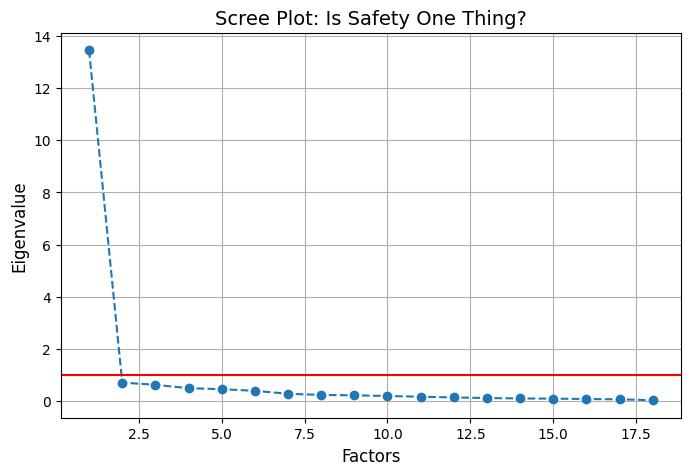

In [11]:
#EFA, KMO code block
import pandas as pd
import numpy as np
import ast
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# CONFIGURATION
# =========================================================
INPUT_FILE = "FINAL_MERGED_FOR_IRT.csv"
OUTPUT_SCREE_PLOT = "efa_scree_plot.png"
OUTPUT_LOADINGS = "efa_factor_loadings.csv"

# =========================================================
# 1: Data preparation
# =========================================================
print("Loading data...")
df = pd.read_csv(INPUT_FILE)

# 1. Parse Tags (violence, hate, fraud, etc.)
print("Parsing tags...")
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# 2. Explode Tags
# Note: Many multijail prompts have multiple tags, which is why if a prompt has 2 tags, it becomes 2 rows. This ensures the prompt counts for BOTH categories.
df_exploded = df.explode('tags')

# 3. (Safe = 1, Unsafe = 0)
df_exploded = df_exploded[df_exploded['label'].isin(['safe', 'unsafe'])]
df_exploded['score'] = df_exploded['label'].map({'safe': 1, 'unsafe': 0})

#----------
# 4. Create the "Student" ID
# A "Student" is a specific Model Configuration operating in a specific Language.
# Example: "Llama3_Standard_ar" is one student. "Llama3_Standard_en" is another.
#Note to Sang + self: This is because we want to see if safety is different with specific "tags" (fraud, violence), etc right.
#Each jailbreaking non-english prompt has the same tags as its English counterpart, so we can just treat it as another test-taker for determining tag correlations.
df_exploded['student_id'] = df_exploded['config'] + "::" + df_exploded['language']


#df_exploded['student_id'] = df_exploded['config'].
#NOTE: Other option, normalizing within language, leads to a KMO score of 0.942 (basically the same)
#----------

category_scores = df_exploded.groupby(['student_id', 'tags'])['score'].mean().reset_index()
efa_matrix = category_scores.pivot(index='student_id', columns='tags', values='score') #set up efa_matrix

# 7. Handle Missing Data (From filtering out "invalid" responses)
# If a model missed a specific category entirely , fill with column mean
if efa_matrix.isnull().sum().sum() > 0:
    print(f"⚠️ Warning: Filling {efa_matrix.isnull().sum().sum()} missing category scores with mean.")
    efa_matrix = efa_matrix.fillna(efa_matrix.mean())
    #note to self: EFA requires full matrix which is why this step is required.

print("-" * 40)
print(f"✅ Matrix Ready: {efa_matrix.shape[0]} Students x {efa_matrix.shape[1]} Categories")
print("-" * 40)

# =========================================================
# STEP 2: KMO
# =========================================================

kmo_all, kmo_model = calculate_kmo(efa_matrix)
print(f"KMO Score: {kmo_model:.3f}")

# =========================================================
# STEP 3: RUN EFA (Eigenvalues)
# =========================================================
# We run with rotation=None first to check the raw eigenvalues. Note to self: Rotation just makes it cleaner, not too useful to know
fa = FactorAnalyzer(n_factors=efa_matrix.shape[1], rotation=None)
fa.fit(efa_matrix)

# Get Eigenvalues
ev, v = fa.get_eigenvalues()

print("\n📊 EIGENVALUES (Variance Explained):")
for i, val in enumerate(ev[:5]): # Print top 5 [:5]
    print(f"Factor {i+1}: {val:.4f}")

# Check Unidimensionality Hypothesis
ratio = ev[0] / ev[1]
print("-" * 40)
print(f"🏆 DOMINANCE RATIO (Factor 1 / Factor 2): {ratio:.2f}")
if ratio > 3.0:
    print("✅ CONCLUSION: Safety is likely UNIDIMENSIONAL (Strong primary factor).")
else:
    print("⚠️ CONCLUSION: Safety might be MULTI-DIMENSIONAL.")
print("-" * 40)

# =========================================================
# STEP 4: VISUALIZATION (The Scree Plot)
# =========================================================

plt.figure(figsize=(8, 5))
plt.plot(range(1, efa_matrix.shape[1]+1), ev, marker='o', linestyle='--')
plt.title('Scree Plot: Is Safety One Thing?', fontsize=14)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='-') # Kaiser criterion line >0.9
plt.savefig(OUTPUT_SCREE_PLOT)
print(f"📈 Scree Plot saved to {OUTPUT_SCREE_PLOT}")

# =========================================================
# STEP 5: FACTOR LOADINGS (What are the factors?)
# =========================================================
# If multi-dimensional, what groups together? (Violence? Fraud?)
# We fit again with 3 factors just to see the structure
fa_rotated = FactorAnalyzer(n_factors=3, rotation='varimax')
fa_rotated.fit(efa_matrix)

loadings = pd.DataFrame(fa_rotated.loadings_, index=efa_matrix.columns, columns=['Factor1', 'Factor2', 'Factor3'])
loadings.to_csv(OUTPUT_LOADINGS)
print(f"📄 Factor Loadings saved to {OUTPUT_LOADINGS}")
print("\nTop Categories contributing to Factor 1 (General Safety):")
print(loadings['Factor1'].sort_values(ascending=False).head(5))


#limitations
#Some tags are almost always moving together (which is consistent with a dominant factor)
#Some categories have near-zero variance (e.g., almost always safe or almost always unsafe)